## Action-conditional scene rendering for agents in 3D Unity games

In [ ]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append("../src")
from datasets import * 
from utils import * 

%load_ext autoreload
%autoreload 2

## Load Unity game dataset

In [2]:
n_actions = {
    'PushBlockCamera': 6,
    'HallwayCamera': 4,
    'PyramidsCamera': 4 
}
n_steps = 8

In [3]:
data_dir = "/home/yueqi/Dropbox/data_large/gqn_dataset/PyramidsCamera3/test/"

In [4]:
dataset = AgentScenesUnity(root_dir=data_dir, 
                    n_actions=n_actions['PyramidsCamera'], 
                    n_timesteps=n_steps, use_all_steps=True) 

In [5]:
len(dataset)

1000

## Load trained GQN model

In [6]:
log_dir = "/home/yueqi/Dropbox/data_large/gqn-pytorch/output/gqn-PyramidsCamera-GQNTimeSeriesLSTM-20181210-065404/"
model_checkpoint = os.path.join(log_dir, "checkpoints/model-20000.pt")
checkpoint_name = os.path.basename(model_checkpoint).split(".")[-2]
print(checkpoint_name)

model-20000


In [7]:
model = torch.load(model_checkpoint, map_location="cuda:0")

/home/yueqi/anaconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:446: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/yueqi/anaconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:446: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/yueqi/anaconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:446: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.AvgPool2d' has changed. you can retrieve the original 

## Action-conditional scene rendering 

Each rendered scene is conditioned on current action and scenes from previous time steps

In [8]:
result_dir = os.path.join(log_dir, 'predict_full_' + checkpoint_name)
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

In [9]:
x_all, v_all, actions_all = dataset[121]
x_all = np.array(x_all)
x_all.shape

(108, 3, 64, 64)

In [10]:
render_list = []
for i in range(len(x_all)-8):
    render, gt, action, loss = render_next_action(model, dataset, 121, 7, start=i, end=i+7, 
                                                  render_func=sample_multiview_lstm, figdir=result_dir, device="cuda")
    render_list.append(render[action])

/home/yueqi/anaconda/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/yueqi/anaconda/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Compare rendered images side-by-side with ground truth

In [11]:
render_arr = np.array(torch.stack(render_list).to('cpu'))
render_arr = render_arr.transpose((0,2,3,1))

In [12]:
beginning = np.array(x_all[:6]).transpose((0,2,3,1))

In [13]:
render_fill = np.concatenate([beginning, render_arr])
render_fill.shape

(106, 64, 64, 3)

In [14]:
ground_truth = x_all.transpose((0,2,3,1))[:-2]
ground_truth.shape

(106, 64, 64, 3)

In [15]:
merged = np.concatenate([ground_truth, render_fill], axis=1)
merged.shape

(106, 128, 64, 3)

In [16]:
merged2 = np.concatenate([ground_truth, render_fill], axis=2)
merged2.shape

(106, 64, 128, 3)

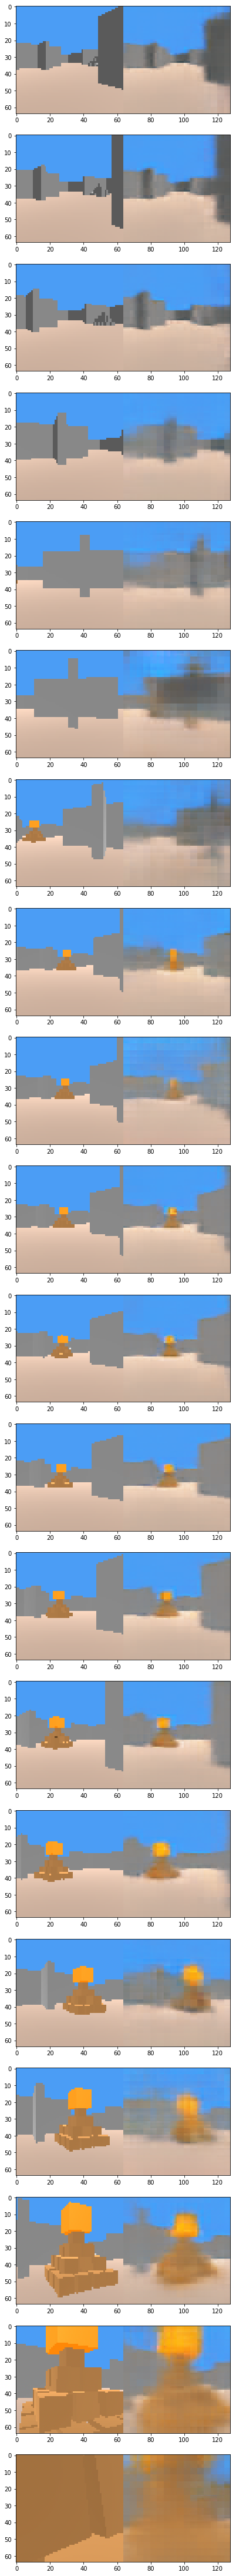

In [17]:
fig, axes = plt.subplots(20, 1, figsize=(8, 4*20))
for i in range(20):
    axes[i].imshow(merged2[70 + i])

## Save images

In [18]:
for i in range(len(render_fill)):
    plt.imsave("data/pyramids_render_121/{0:03d}.jpg".format(i), render_fill[i])
for i in range(len(merged)):
    plt.imsave("data/pyramids_render_121_merge/{0:03d}.jpg".format(i), merged[i])
for i in range(len(merged2)):
    plt.imsave("data/pyramids_render_121_merge2/{0:03d}.jpg".format(i), merged2[i])